# Neural Network Q Learning, a Tic-tac-toe player that learns - kind of

In the previous part we implemented a player that uses a table to learn the Q function. This worked quite well. In particular because Tic-tac-toe only has very few states and each state only has very few possible moves. For a more complicated game, such as Go or Chess, the tabular approach would not be feasible.

What, if we could write a program that mimics the behaviour of the Q function without actually having to store the exact value for every state and action? Obviously, after a bit of practice, humans are able to spot certain patterns in the game position and deduce general rules of how to react to them. Can we teach a program to do something similar?

Exactly this is the idea when using a Neural Network. Neural Networks are generally used to do one of the following two things:

1. Classify the input: E.g. if the input is a picture, the output could be what kind of animal is in the picture.
2. Mimic a complex function (also called regression): Given an input value for the complex function, correctly predict what the output would be. 

We will use the second use-case and train a Neural Network to mimic the Q function. Ideally, using significantly less space than the tabular Q function does.

<div class="alert alert-block alert-info">
Time for some acknowledgments: <br><br>

Most of what I know about reinforcement learning, I got from the excellent [tutorials by Arthur Juliani](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0).<br>
<br>
After that I read [Reinforcement Learning - An Introduction](https://mitpress.mit.edu/books/reinforcement-learning) by Richard S. Sutton and Andrew G. Barto for a more in-depth understanding of the topic. <br>
<br>

I also found the tutorial [Deep reinforcement learning, battleship](https://efavdb.com/battleship/) by Jonathan Landy quite interesting and useful. The, at least to me, rather unorthodox choice to feed the reward into the network via the learning rate, however, I find extremely puzzling and confusing. I suspect mathematically it is somehow equivalent to feeding it in via the label, but how this exactly works is beyond me.

</div>

## Preparations

In order to execute the code in this notebook you will have to install PyTorch and its dependencies. At the time of writing this, the instructions of how to do so can be found [PyTorch Website](https://pytorch.org/get-started/locally/). If the link should no longer work, a quick Google should be able to point you in the right direction.

If you do not have a modern GPU, this choice is simple: Install without GPU support.

If you do have a modern GPU, you can try to install the GPU version, but this is a much more complex and difficult process than installing the non-GPU version. In particular, you will have to install all kinds of GPU libraries before you can install PyTorch. Only do so if you are comfortable with complex software installations and if you are able to deal with the messy fallout that inevitably happens if you get stuck in the middle of the process and have to roll back what you have done so far. Should you succeed, however, the code in this and the following notebooks will run noticeably faster than without GPU support.

## A short introduction to Artificial Neural Networks

Artificial Neural Networks are made up of *Nodes*. A *Node* takes 1 or more inputs. It combines the inputs linearly, i.e. it multiplies each input $i_x$ with a dedicated weight $w_x$ for that input and adds them all up. On top of that it adds another value, the so-called *bias*. It then applies an activation function $f_a$ to the result and sends it to one or more outputs $O$:

![Title](./Images/NN_Node.PNG)

<div class="alert alert-block alert-info">
Side Note: The *bias* effectively turns the linear function of the node into an affine linear function, i.e. a line that does not necessarily run through the point $(0,0)$. Without that, no matter what the trained weights say, the output to input $0$ would always be $0$. There are other ways to achieve that, and indeed you will find them in some books. E.g. by adding another input to every node with the fixed input value of 1. Mathematically this is just the same.
</div>

The activation function allows us to achieve non-linearity. Without it, we would only be able to mimic linear functions. Also, without it, multi-layer networks would not make any sense. They would just be a combination of linear functions and as any Algebra textbook would tell us: a combination of linear function is no more than a linear function itself. I.e. we could just collapse all layers into one and do the whole computation more efficiently.

Nodes that have no connections coming in are called *Input Nodes* and nodes having no connections coming out are called *Output Nodes*. Nodes are arranged in layers, with the first layer consisting of Input Nodes and the last layer consisting of Output Nodes. The other layers are also often referred to as *Hidden Layers* as the user will only ever interact with the Input and Output layers.

A simple network with one hidden layer may look like this (source [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png)):

![Title](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png)

By setting the weights in the nodes *just right* the neural network can mimic other complex functions with the same number of input and output values. 

The special things about an artificial neural network is, that it can be trained to learn those weights and biases. By giving the Neural Network feedback on how good its output was, it can adjust its weights and biases in a process called *Gradient Descent*. For networks with more than one hidden layer it also uses a process called *Back-propagation* to apply the gradient layers that are further away from the output layer. 

For a more detailed introduction to Artificial Neural Networks, see [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network), or any number of other sources a quick Google will yield.

## A short introduction to PyTorch

[PyTorch](https://pytorch.org/) is an Open Source Machine Learning framework. It allows us to specify, train, and run Artificial Neural Networks at a very high level in Python. I will not give a detailed introduction in how it works, or how to use it here. I will comment the code that we use as I go, but if you get stuck, and it all just doesn't make any sense, please read some of the introduction resources or similar PyTorch tutorials and then come back here and give it another go.

## A Neural Network to play Tic-tac-toe

To train a Neural Network to play Tic-tac-toe, we need to define the following things:

* The Topology of the network, i.e. how do the input and output layers look like. How many hidden layers and how big?
* A *loss function*. The loss function will take the output of the Neural Network and return a value indicating how good that output was.
* A training part which will try to adjust the weights in the Neural Network as to minimise the loss function.

### The basic Tic-tac-toe Q learning Graph

We will experiment with some different graphs, but the basic shape will always be as follows:

* An input layer which takes a game state, i.e. the current board, as input. 
* One or more hidden layer.
* An output layer which will output the Q value for all possible moves in that game state.
* As loss function we will use [Mean Squared Error](https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) which is a generic and popular loss function for regression, i.e. learning to mimic another function.
* The input for the loss function will be the output of the Neural Network and our updated estimate of the Q function by applying the discounted reward. I.e. the loss will be the difference between the output of the Neural Network and our estimate of the Q function after applying the discounted reward.
* We will mostly use the [Gradient Descent Optimizer](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html) for training - i.e. to adjust the weights in the Neural Network. There are other reasonable, or potentially even better, options as well. Feel free to experiment - report back how it went.

<div class="alert alert-block alert-info">
There are many different other ways how we could do this:<br/>
We could feed an action into the network together with the board state, and have a single output value indicating the value of this action. <br/>
We could also just have single output value encoding the value of the state and use that as a proxy for the State / Action pairs that lead to that state.<br/>
And many more.
</div>

### The input layer

There are also many options how we can encode the input to the Neural Network. We could just have a single node and feed the unique hash value of the board into it. Or we could feed an array into it with each element encoding the value of the piece on it. Conventional wisdom however seems to be that Neural Networks work best in cases like this with binary arrays as input. Blindly trusting this advice, our input will be an array of 27 (= 3 * 9) bits with the first 9 bits set to 1 at the positions of the crosses, the next 9 bits set to 1 at the position of the Naughts - or the other way round, I forgot which way it was -, and the final 9 bits set to 1 at the empty positions.

<div class="alert alert-block alert-info">
Side Note: I didn't even try any of the other options. Feel free to give it a go and let me know how it went. In particular if you find that one of the other options actually works better.
</div>

### The output layer

The output layer will have 9 nodes / output values, one for each position of the board that we could play. We will interpret the value of a node as the Q value of the corresponding move. 

We will be ignoring the fact that for a particular board state some position would already be taken and no longer an option. The player will deal with this when choosing a move and ignore illegal moves no matter what their Q values are. That is, we do not try to teach the Neural Network what moves are legal or not. Again, general advice you find is that this is the better approach - we have to be careful though to also ignore these moves when computing $$max_a Q(S', a)$$ for the Q Value update.

## Time to look at the code

The first version of our Neural Network Q-Learning Player can be found in the file [SimpleNNQPlayer.py](https://github.com/fcarsten/tic-tac-toe-pytorch/blob/master/tic_tac_toe/SimpleNNQPlayer.py).

Let's look at some selected parts of the code. The file define two classes: 

* `QNetwork` which builds the Neural Network graph.
* `NNQPlayer` which implements the game playing logic and utilises the `QNetwork` class to determine moves.

### A Closer look at `QNetwork`

The class `QNetwork` has 3 important methods `__init__`, `forward` and `train_batch`.

The method  

```Python
class QNetwork(nn.Module):
    def __init__(self, learning_rate: float, device: torch.device):
        super().__init__()
        self.device = device

        self.feature_layer = nn.Sequential(OrderedDict([
            ('Input_Layer', nn.Linear(BOARD_SIZE * 3, BOARD_SIZE * 3 * 9)),
            ('Activation_1', nn.ReLU()),
            ('Output_Layer', nn.Linear(BOARD_SIZE * 3 * 9, BOARD_SIZE))
        ])).to(device)

        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
```

is called when the class is instantiates. It builds the neural network and creates the loss function and optimiser.

This method creates  the board input layer, one hidden layer with 9 times the nodes of the input layer (`BOARD_SIZE * 3`), i.e. 243 nodes and the output layer with 9 nodes, one for each possible move.

It uses [ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu) as activation function. There are other options you could try, e.g. [tanh](https://docs.pytorch.org/docs/stable/generated/torch.nn.Tanh.html), but ReLU is a common choice.

The method

```Python
class QNetwork(nn.Module):
    [...]
    def forward(self, x):
        return self.feature_layer(x)
```

is called when input data is fed into the network. It just passes the input data through the layers we defined in `__init__` and returns the output.

The method

```Python
class QNetwork(nn.Module):
   [...]
   def train_batch(self, inputs, targets, writer=None, name = None, game_number=-1):
        self.optimizer.zero_grad()
        q_pred = self.forward(inputs)
        loss = self.loss_fn(q_pred, targets)
        loss.backward()
        # Log Loss to TensorBoard
        if writer:
            writer.add_scalar(f'{name}/Training_Loss', loss, game_number)

            if game_number % 100 == 0:
                self.log_weights(writer, name, game_number)

        self.optimizer.step()
        return loss.item()  # Return loss for logging
```

is called to when we want to train the network. We pass in a batch of inputs and training targets. The method computes the output of the network for the input batch, computes the loss with respect to the targets, computes the gradients via back-propagation, and then applies the optimiser to adjust the weights in the network.

All in all this is a very simple network, with only one, small hidden layer:

![Title](./Images/SimpleNN.PNG)

Green Nodes are where we feed input into the Network and Orange Nodes are where we retrieve the results. We don't even do the last step in the diagram, ie compute move probabilities from the Q values. We just use the max Q value directly to choose our move as softmax is monotonic and applying it would not change the chosen move.

### A closer look at `NNQPlayer`

This class implements the `Player` interface and provides the actual game playing logic. For each move, it feeds the current board state into its Neural Network and then plays the move with the highest Q value. Actually, it plays the move with the highest Q value amongst all *legal* moves. In this implementation we do not try to teach the Network to recognise and discard illegal moves - we just ignore them when making a move.

While playing the game we record the data that we will later need to train the network. We record all board states, the Q values of all moves in those states, all moves that were made during the game, and the maximum Q value of all moves in the new state for every move (i.e. the q value which we pass down with a discount).

After the game is over we update the Q value of every move according to the formula: $$ Q(S,A) = \gamma * max_a Q(S', a) $$ with $\gamma$ being the discount factor and $max_a Q(S', a)$ the maximum Q value of all possible moves in state $S'$, with $S'$ being the state we ended up in after doing move $A$ in state $S$.

We then feed the game states and our updated Q value estimates into the Gradient Descent Optimizer and ask it to change its weights such that the Q values get close to our updated estimates.

The Q values for a board state can be queried in like this:

```Python
class NNQPlayer(Player):
    [...]
    def move(self, board: Board):
        [...]
        state_tensor = self.board_state_to_nn_input(board.state)

        # Inference only, no graph
        with torch.no_grad():
            # Detached copy stored on the training device
            q_values = self.nn(state_tensor.unsqueeze(0))[0]
```

The computation of the next move happens in `move`:

```Python
class NNQPlayer(Player):
    [...]
    def move(self, board: Board):
        self.move_step += 1

        state_tensor = self.board_state_to_nn_input(board.state)
        if self.training:
            self.state_log.append(state_tensor)

        # Inference only, no graph
        with torch.no_grad():
            # Detached copy stored on the training device
            q_values = self.nn(state_tensor.unsqueeze(0))[0].detach().clone()
            if self.training:
                self.q_log.append(q_values)

            [...]

            occupied_mask = torch.as_tensor(board.state != EMPTY, device=self.device, dtype=torch.bool)
            logits = q_values.clone()
            logits[occupied_mask] = -float('inf')
            move = int(torch.argmax(logits).item())

            if self.training:
                if self.action_log: # Skip on first move, ie when action_log is empty
                    self.next_value_log.append(torch.max(q_values).item())
                self.action_log.append(move)

            _, res, finished = board.move(move, self.side)
        return res, finished
```

The new Q value estimates get computed and the Neural Network gets trained in `final_result`:

```Python
class NNQPlayer(Player):
    [...]
    def final_result(self, result: GameResult):
        if not self.training:
            return

        reward = self.get_reward_value(result)

        self.next_value_log.append(reward)

        states = torch.stack(self.state_log)
        q_pred = torch.stack(self.q_log)
        targets = q_pred.clone().detach()

        actions = torch.tensor(self.action_log, device=self.device)
        next_vals = torch.tensor(self.next_value_log, device=self.device)

        # 3. Vectorized Bellman Update
        # Identify indices for intermediate moves and the terminal move
        num_moves = len(actions)
        row_indices = torch.arange(num_moves, device=self.device)

        # Calculate discounted values for all (will be wrong for the last one)
        bellman_targets = self.reward_discount * next_vals

        # Override the very last target with the pure reward (no discount)
        bellman_targets[-1] = reward

        # Update only the Q-values for the actions that were actually taken
        targets[row_indices, actions] = bellman_targets

        loss = self.nn.train_batch(states, targets, writer=self.writer,
                                      name=self.name, game_number=self.game_number)

```


## Time to run the code

So, how well does this network perform? Let's have it play a couple of games and see. First, let's set things up:

In [8]:
from tic_tac_toe.Board import Board
from util import evaluate_batch
from tic_tac_toe.Player import Player

def evaluate_players(p1 : Player, p2 : Player, games_per_battle = 100, num_battles = 100):
    board = Board()

    p1_wins = []
    p2_wins = []
    draws = []
    game_number = []
    game_counter = 0


    for i in range (num_battles):
        p1win, p2win, draw = evaluate_batch(p1, p2, games_per_battle, False)
        p1_wins.append(p1win)
        p2_wins.append(p2win)
        draws.append(draw)
        game_counter=game_counter+1
        game_number.append(game_counter)

    return game_number, p1_wins, p2_wins, draws


The function `evaluate_players` takes two `Player` objects and pits them against each other in `num_battles` battles, with each battle consisting of `games_per_battle` games.

### Against the Random Player

Let's play some games. Player 1 will be our Neural Network player, and Player 2 will be the Random Player. It should be easy for the Neural Network player to win most games, but we hope it will learn to win much more than we would expect from a Random Player playing first.

After 100 game we have draws: 15, Player 1 wins: 61, and Player 2 wins: 24.
Which gives percentages of draws: 15.00%, Player 1 wins: 61.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 6, Player 1 wins: 84, and Player 2 wins: 10.
Which gives percentages of draws: 6.00%, Player 1 wins: 84.00%, and Player 2 wins:  10.00%
After 100 game we have draws: 16, Player 1 wins: 71, and Player 2 wins: 13.
Which gives percentages of draws: 16.00%, Player 1 wins: 71.00%, and Player 2 wins:  13.00%
After 100 game we have draws: 18, Player 1 wins: 68, and Player 2 wins: 14.
Which gives percentages of draws: 18.00%, Player 1 wins: 68.00%, and Player 2 wins:  14.00%
After 100 game we have draws: 18, Player 1 wins: 72, and Player 2 wins: 10.
Which gives percentages of draws: 18.00%, Player 1 wins: 72.00%, and Player 2 wins:  10.00%
After 100 game we have draws: 19, Player 1 wins: 74, and Player 2 wins: 7.
Which gives percentages of draws: 19.00%, Player 1 wins: 74.00%, and Player 2 wins:  7.

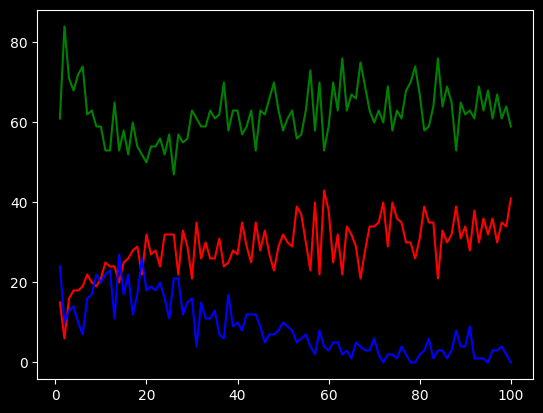

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.SimpleNNQPlayer import NNQPlayer

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Since there are some non-deterministic parts in this, your results will vary to a degree, but you should see the Neural Network player improve its game over time, in the end winning the vast majority of games. In particular, it should win significantly more games than the Random Player. In my runs it usually ended up winning about 90% of games on average in the end and lose less than 10%.

So, how well does it play against a Random Player if it goes second?

After 100 game we have draws: 7, Player 1 wins: 40, and Player 2 wins: 53.
Which gives percentages of draws: 7.00%, Player 1 wins: 40.00%, and Player 2 wins:  53.00%
After 100 game we have draws: 5, Player 1 wins: 39, and Player 2 wins: 56.
Which gives percentages of draws: 5.00%, Player 1 wins: 39.00%, and Player 2 wins:  56.00%
After 100 game we have draws: 3, Player 1 wins: 38, and Player 2 wins: 59.
Which gives percentages of draws: 3.00%, Player 1 wins: 38.00%, and Player 2 wins:  59.00%
After 100 game we have draws: 1, Player 1 wins: 39, and Player 2 wins: 60.
Which gives percentages of draws: 1.00%, Player 1 wins: 39.00%, and Player 2 wins:  60.00%
After 100 game we have draws: 1, Player 1 wins: 39, and Player 2 wins: 60.
Which gives percentages of draws: 1.00%, Player 1 wins: 39.00%, and Player 2 wins:  60.00%
After 100 game we have draws: 5, Player 1 wins: 26, and Player 2 wins: 69.
Which gives percentages of draws: 5.00%, Player 1 wins: 26.00%, and Player 2 wins:  69.00%
Afte

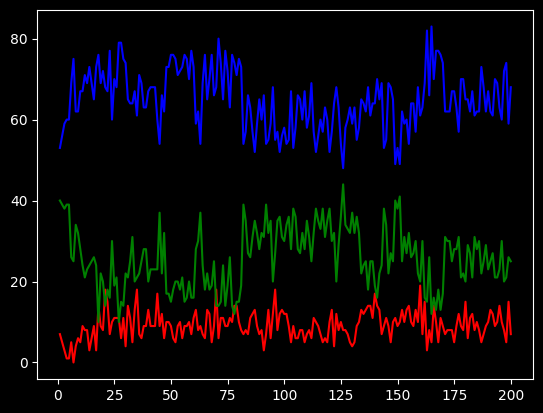

In [10]:
nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer, num_battles=200)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Again, the Neural Network player improves its game over time. In my runs it typically started to beat the Random Player more often than it lost after about 20 battles and in the end would win about 80% of the games and lose around 20%. 

It is quite notable that in both cases, the player does not play draws very often. In fact, they happen much less often than during pure random play.

## Against the Min Max Player

Let's see how we do against the Min Max player. This time the Neural Network player going first again:

After 100 game we have draws: 88, Player 1 wins: 0, and Player 2 wins: 12.
Which gives percentages of draws: 88.00%, Player 1 wins: 0.00%, and Player 2 wins:  12.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

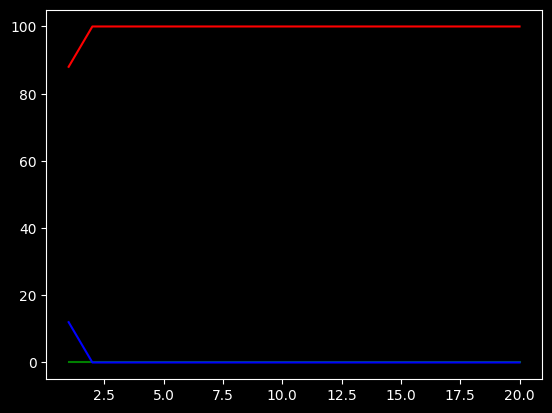

In [17]:
from tic_tac_toe.MinMaxAgent import MinMaxAgent

nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles = 20)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Now, this is a tricky one and you might have to rerun this code block a couple of times to see this effect. It seems that either it converges to 100% draw or 100% losses with no middle ground or change after it reached 100% of either. We'll have to look into this in more detail, but first let's try some other pairings.

Let's try the Neural Network moving second:

After 100 game we have draws: 6, Player 1 wins: 0, and Player 2 wins: 94.
Which gives percentages of draws: 6.00%, Player 1 wins: 0.00%, and Player 2 wins:  94.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 

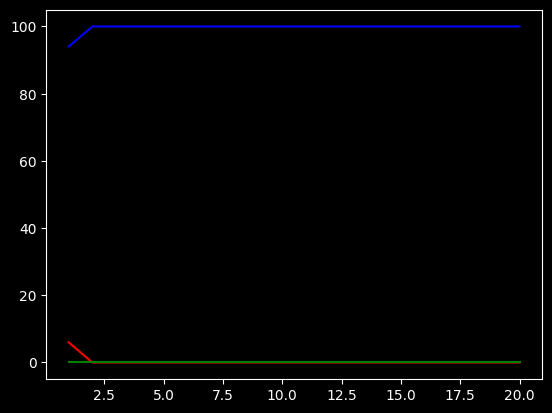

In [18]:
nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles = 20)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Same story it seems: Sometime it converges to 100% draws and sometime to 100% losses. We'll have to come back to this one as well and try to figure out why this is.

## Against the non-deterministic Min Max Player

Before we do this, however, let's try playing against the non-deterministic Min Max algorithm:

After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
Afte

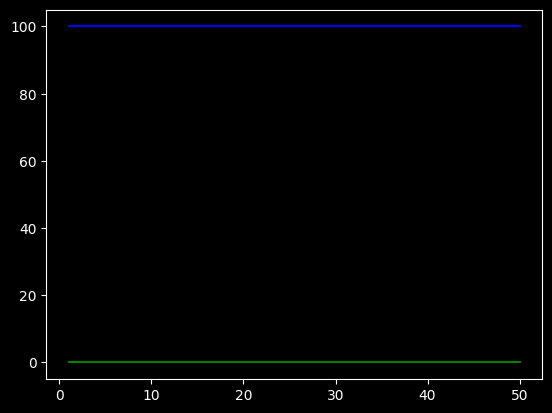

In [13]:
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent

nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rnd_mm_player, num_battles = 50)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Again, results are mixed. Sometimes we get close to 100% draws, but everything between 0% and 100% seems possible.

Let's try going second:

After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 6, Player 1 wins: 94, and Player 2 wins: 0.
Which gives percentages of draws: 6.00%, Player 1 wins: 94.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game w

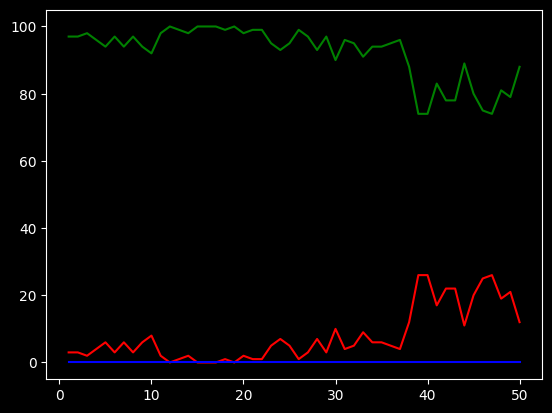

In [15]:
nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(rnd_mm_player, nnplayer, num_battles = 50)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Results here for me are definitively not pretty: In most cases we end up playing slightly better than a random player, but not by much. I never achieved consistently above 10% draws. This is disappointing.
 
## Summary

How did we go overall? Here is a summary of our results with this very simple Neural Network based player:

| Player      | NN Player 1st           | NN Player 2nd          |
|-------------|-------------------------|------------------------|
| Random      | Not bad but not perfect | Kind of but not really |
| Min Max     | Mixed - All or nothing  | Mixed - All or nothing |
| Rnd Min Max | Sometimes / Mixed       | Nope                   |

Not as good as I would have hoped given that mastering Tic-tac-toe is not a particularly hard challenge - at least for a human, even of very young age. So What's going on? Join us again next time when we to try to find out why we get these rather under-whelming results, and if we can find a way to build better networks which overcome these limitations.